In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import module_extraction
import clustering
from module_extraction_ortho import Filters, Modules
#from module_extraction import Filters, Modules

分析対象の指定

In [3]:
# -- 個別画像 --
#input_img_path = '../ModuleExtraction/hokuto/thermal/DJI_0123_R.JPG'
#thermal_npdat_path = "../ModuleExtraction/hokuto/thermal"

# --オルソ画像 --
#input_img_path = 'images/ortho/1391.tif'
input_img_path = 'images/ortho/1577.tif'
#input_img_path = 'images/ortho/izuka.tif'
#input_img_path = 'images/ortho/chiba.tif'

In [4]:
output_dir_path = "./images/"+input_img_path.split("/")[-1][:-4]
print(output_dir_path)

./images/1391


フィルタの適用

In [5]:
#filters = Filters(thermal_npdat_path)
filters = Filters()

In [6]:
img_org = cv2.imread(input_img_path, 0)

/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


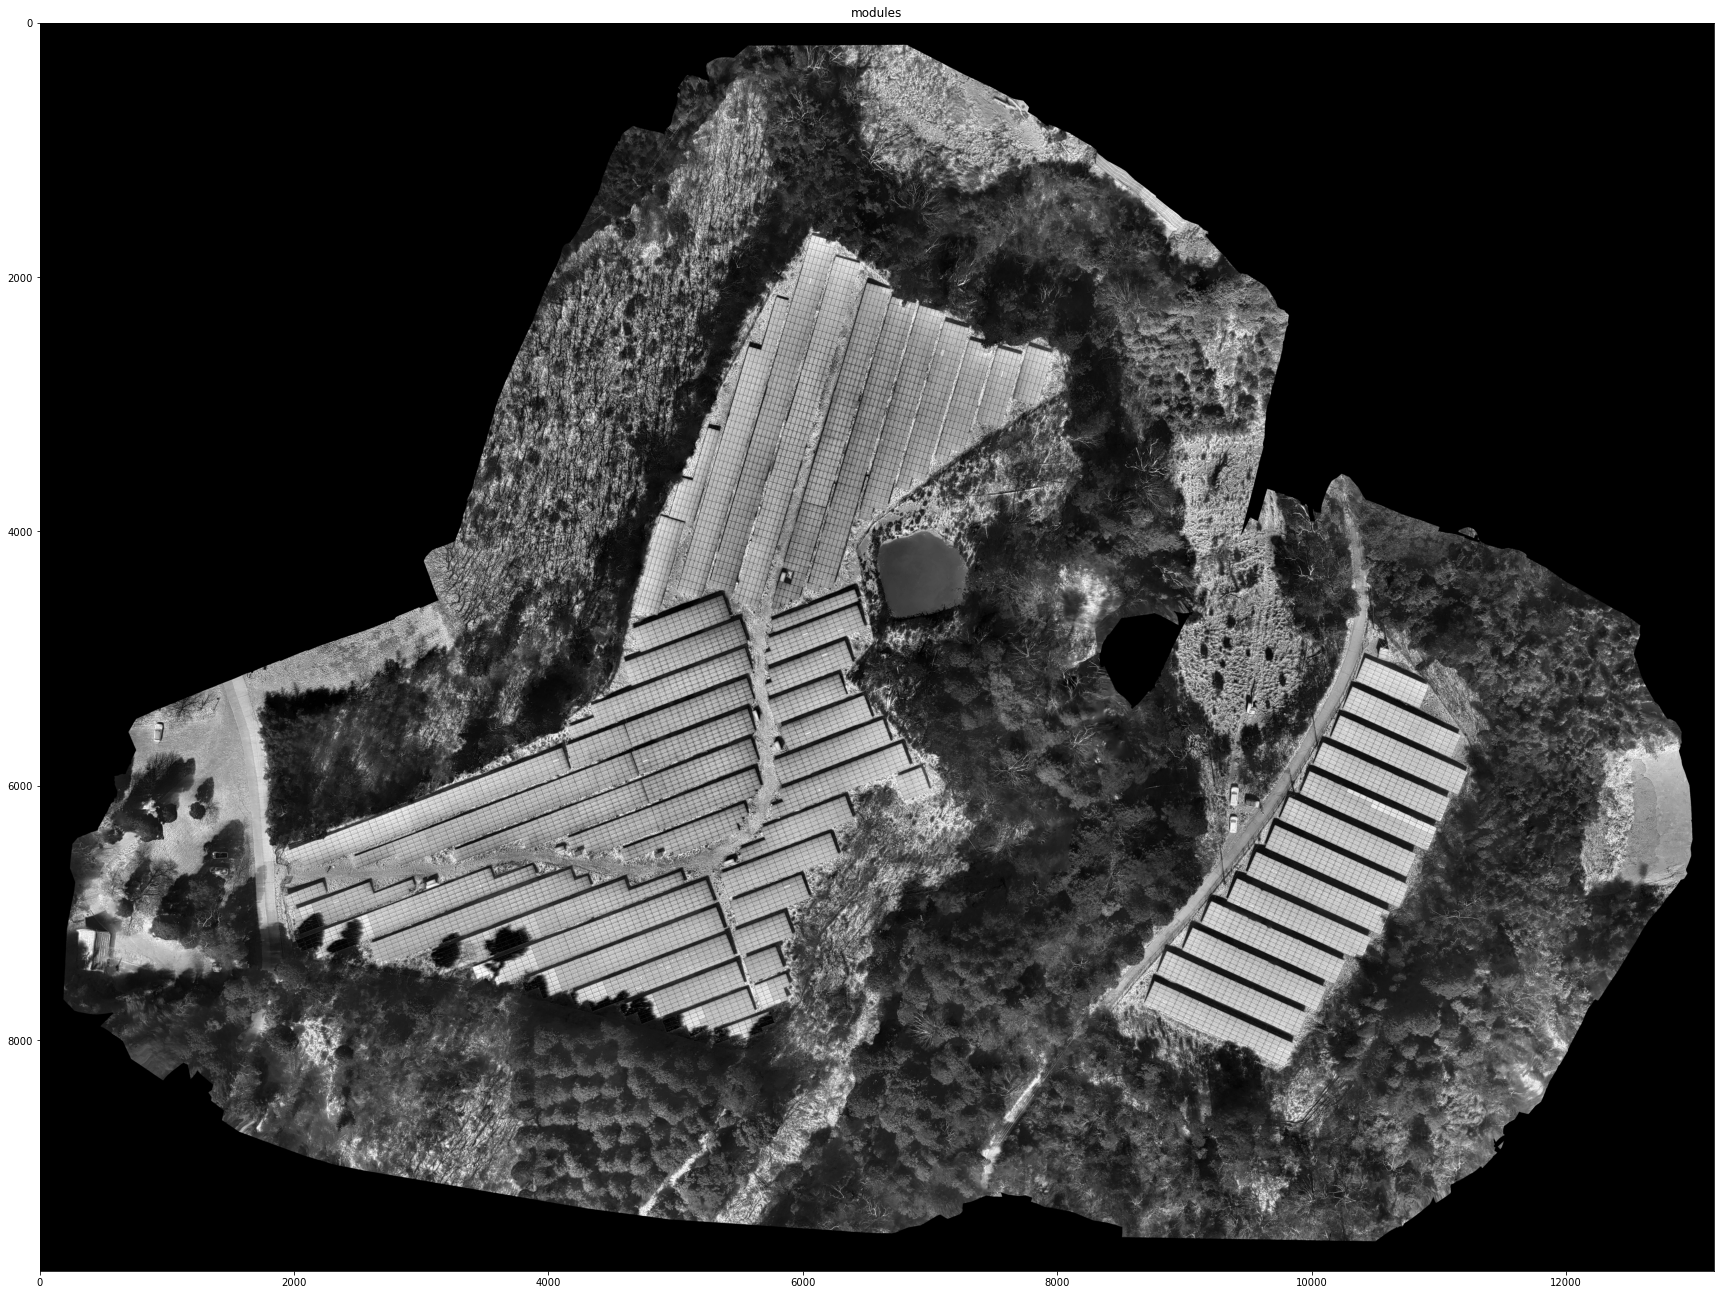

In [7]:
# 元画像
module_extraction.show_img({"modules":img_org},cmap="gray",figsize=(30,30))

In [8]:
# 部分抽出
#img_cut = img_org[6000-1000: 6000+1000, 6000-1000: 6000+1000]
#module_extraction.show_img({"modules":img_cut},cmap="gray",figsize=(30,30))

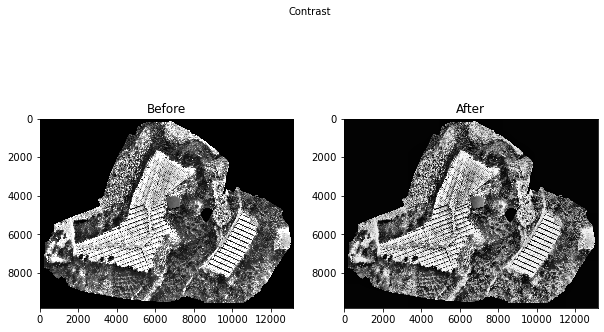

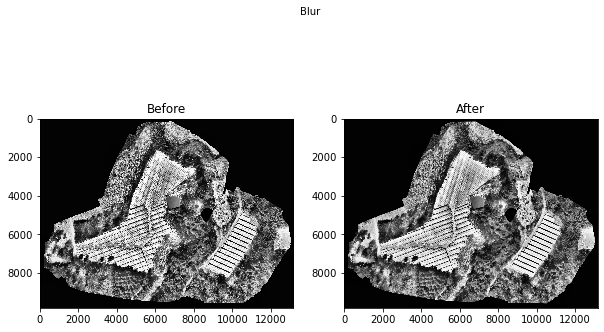

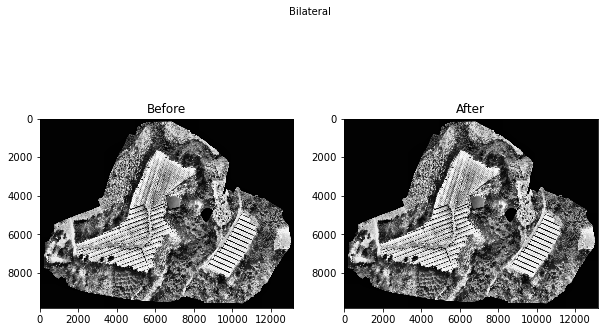

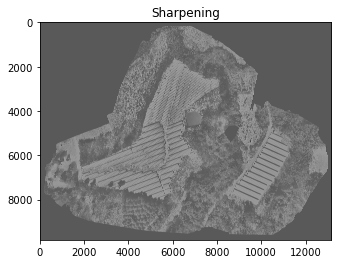

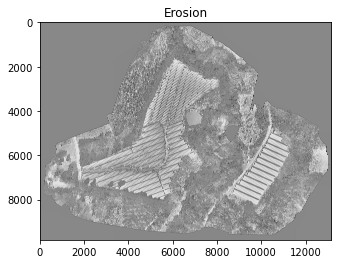

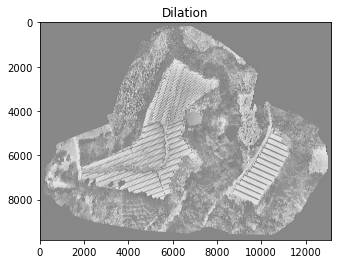

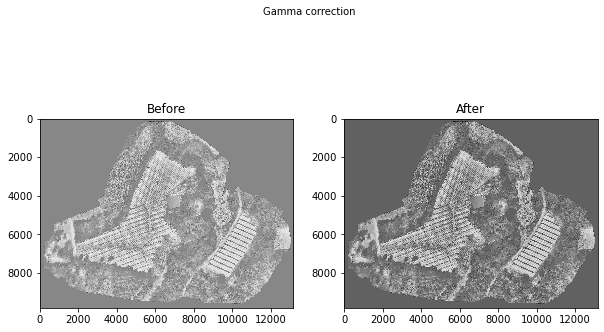

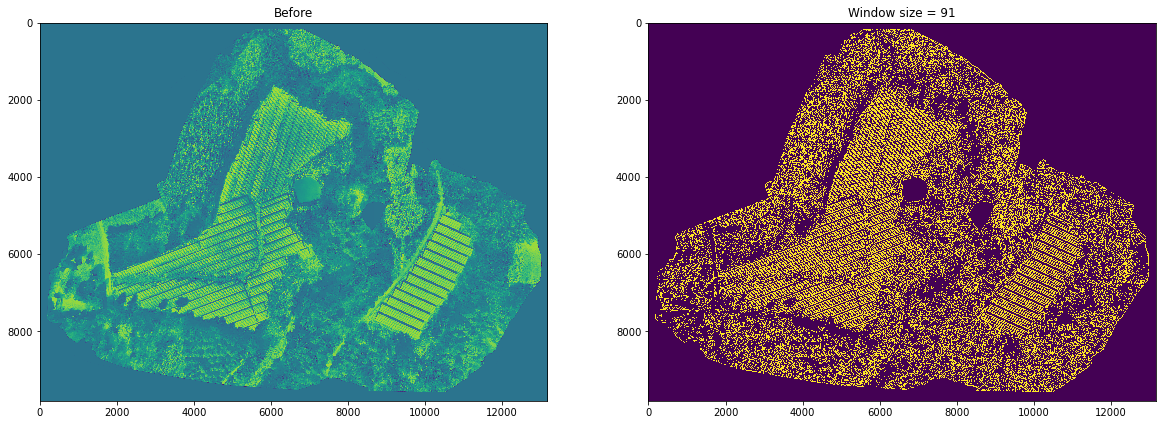

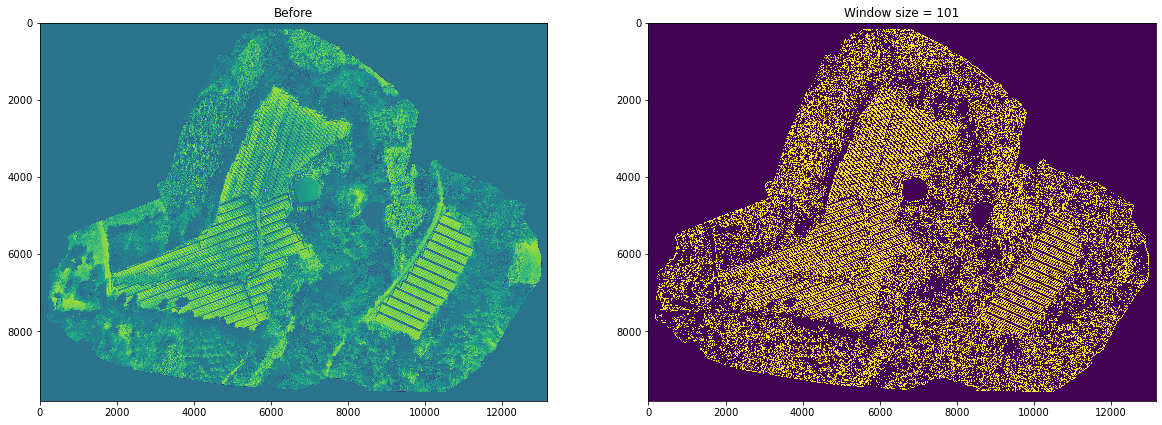

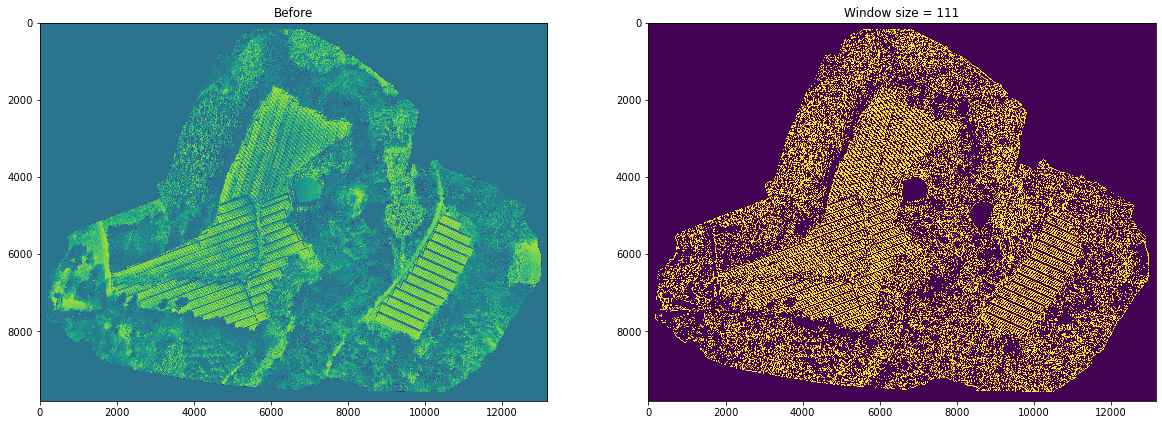

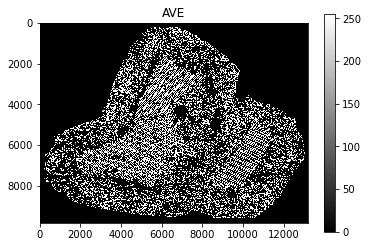

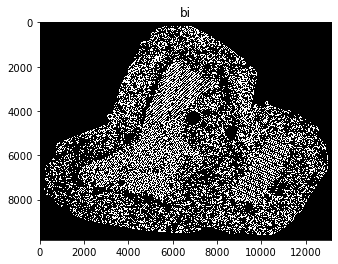

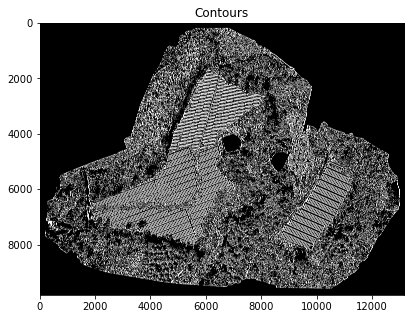

In [9]:
# 前処理
candidate_module_contours = filters.get_module_contours(img_org)

In [10]:
# モジュール抽出画像
img_con = cv2.drawContours(np.zeros_like(img_org), candidate_module_contours, -1, 255, -1)
img_mask = cv2.bitwise_and(img_org, img_con)

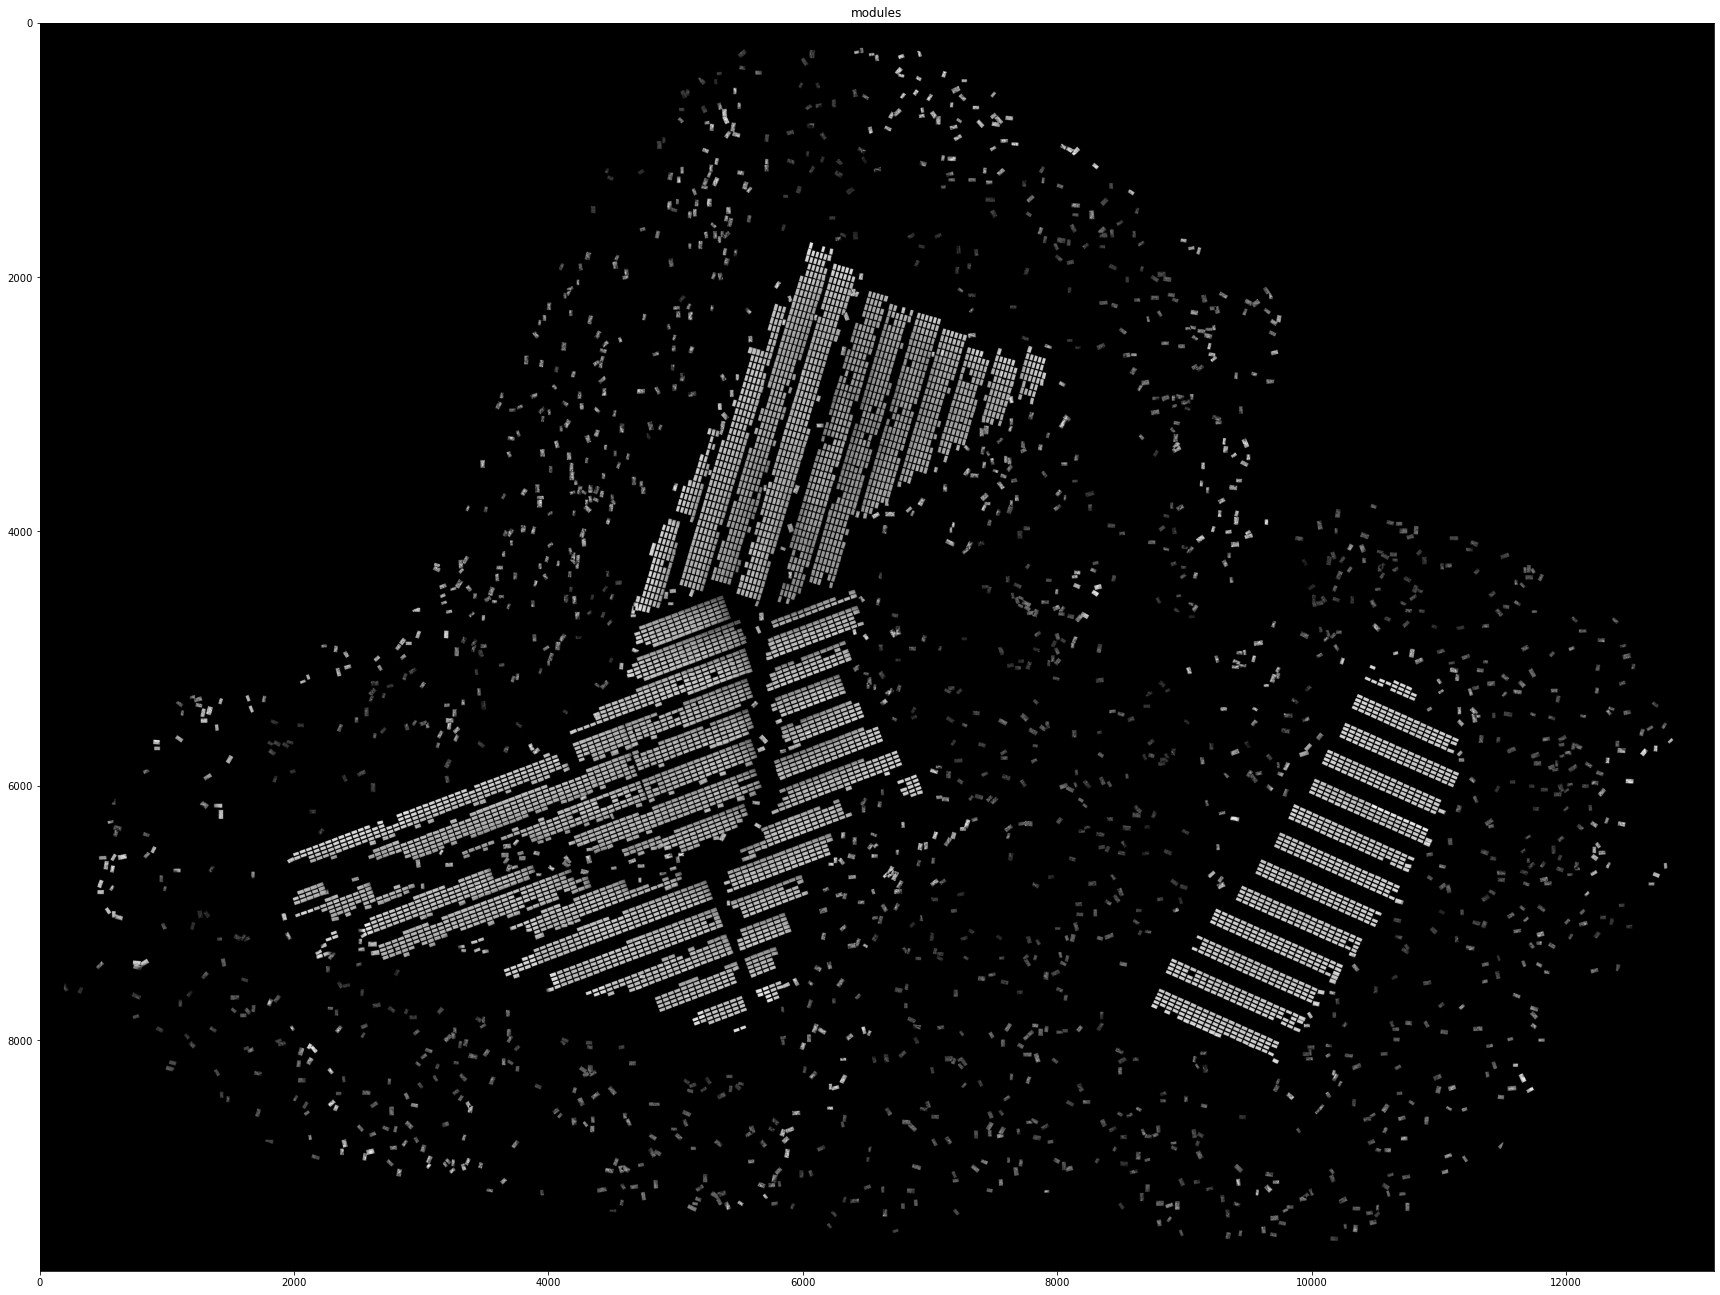

In [11]:
module_extraction.show_img({"modules":img_mask},cmap="gray",figsize=(30,30))

モジュールのクラスタリング

In [12]:
import clustering
modules = Modules(candidate_module_contours)
module_labels = modules.get_dbscan_labels(candidate_module_contours)

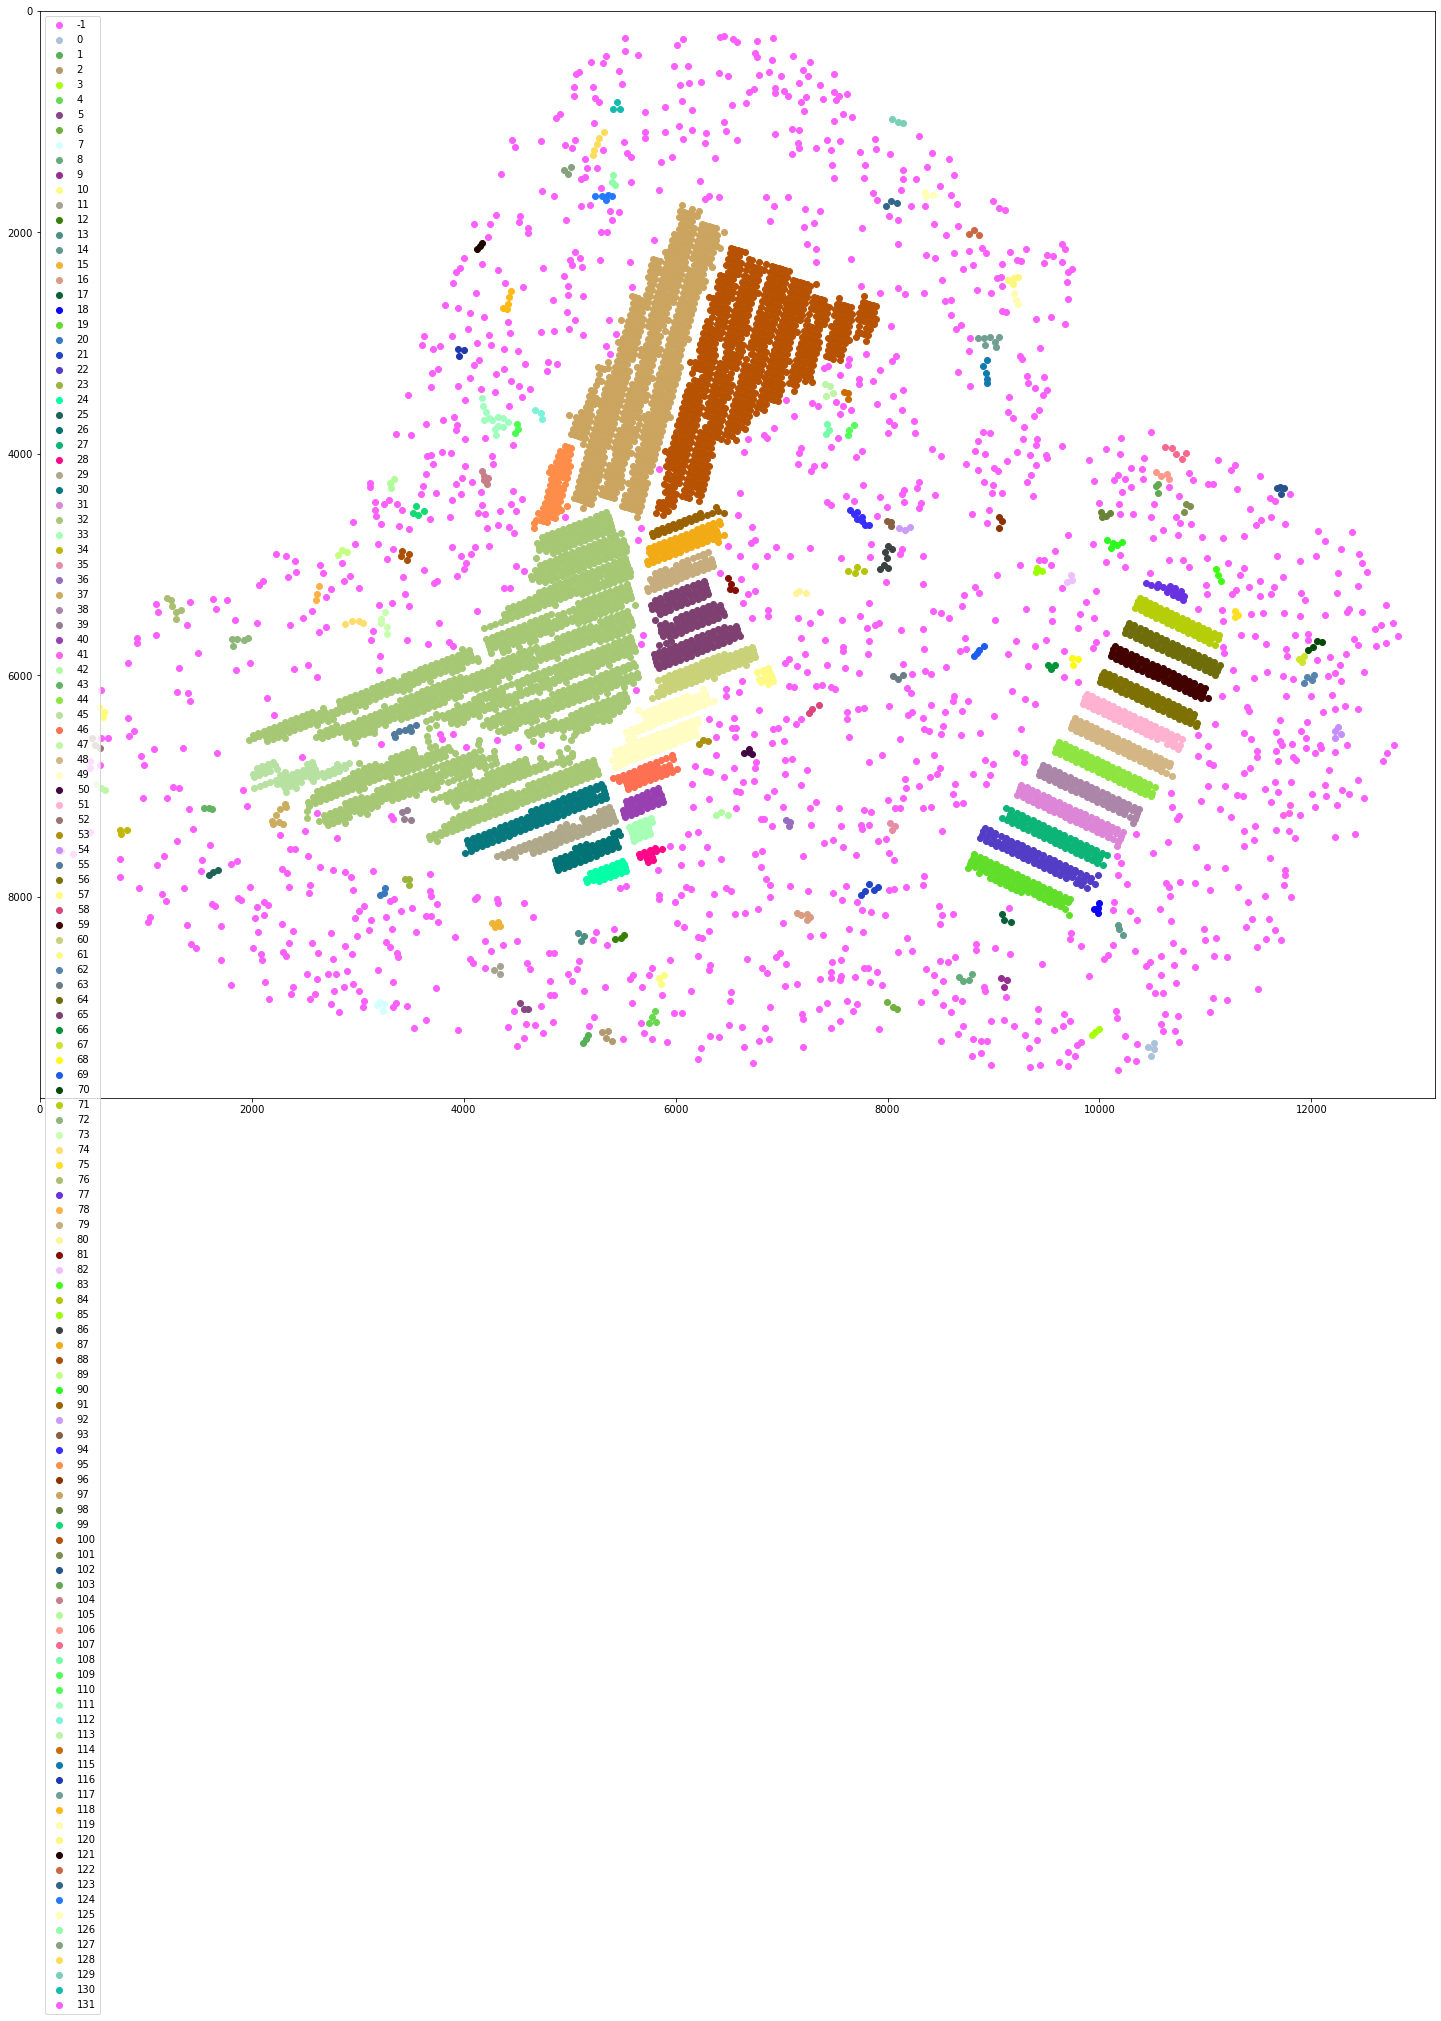

In [13]:
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
#cmap = plt.get_cmap("tab20")
colors = list(matplotlib.colors.XKCD_COLORS.items())[:max(module_labels)]
module_centers = np.array( [c.mean(axis=0) for c in candidate_module_contours] )
for i in range(-1,max(module_labels)):
    data = module_centers[module_labels == i]
    plt.scatter(data[:, 0], data[:, 1], color=colors[i][1], label=str(i))
#plt.scatter(module_centers[:, 0], module_centers[:, 1], color=cmap(module_labels+1), label=)
ax.legend(loc='upper left')
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])
plt.show()

出現頻度の高いラベルのみを残す

In [14]:
from collections import Counter
counter = Counter(module_labels)

In [15]:
counter.most_common

<bound method Counter.most_common of Counter({32: 1843, -1: 1433, 100: 945, 97: 824, 65: 191, 49: 148, 30: 118, 60: 89, 19: 85, 22: 82, 29: 81, 31: 80, 27: 76, 38: 76, 48: 76, 44: 75, 51: 74, 56: 74, 59: 73, 64: 72, 87: 71, 95: 71, 45: 66, 71: 63, 79: 57, 26: 54, 46: 49, 40: 38, 24: 29, 91: 25, 33: 22, 77: 16, 28: 13, 61: 13, 111: 13, 37: 8, 94: 8, 55: 7, 86: 7, 117: 7, 76: 6, 16: 5, 21: 5, 72: 5, 73: 5, 90: 5, 104: 5, 107: 5, 115: 5, 118: 5, 124: 5, 128: 5, 0: 4, 2: 4, 4: 4, 7: 4, 8: 4, 15: 4, 18: 4, 39: 4, 50: 4, 54: 4, 62: 4, 69: 4, 70: 4, 74: 4, 81: 4, 84: 4, 88: 4, 98: 4, 99: 4, 102: 4, 106: 4, 113: 4, 120: 4, 1: 3, 3: 3, 6: 3, 5: 3, 9: 3, 10: 3, 11: 3, 13: 3, 12: 3, 14: 3, 17: 3, 20: 3, 23: 3, 25: 3, 34: 3, 35: 3, 36: 3, 42: 3, 41: 3, 43: 3, 47: 3, 52: 3, 53: 3, 57: 3, 58: 3, 63: 3, 66: 3, 68: 3, 67: 3, 75: 3, 78: 3, 80: 3, 82: 3, 83: 3, 85: 3, 89: 3, 96: 3, 92: 3, 93: 3, 101: 3, 103: 3, 105: 3, 109: 3, 108: 3, 110: 3, 112: 3, 114: 3, 116: 3, 119: 3, 121: 3, 122: 3, 123: 3, 125: 

In [16]:
array_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>20])
module_flags = [label in array_labels for label in module_labels]

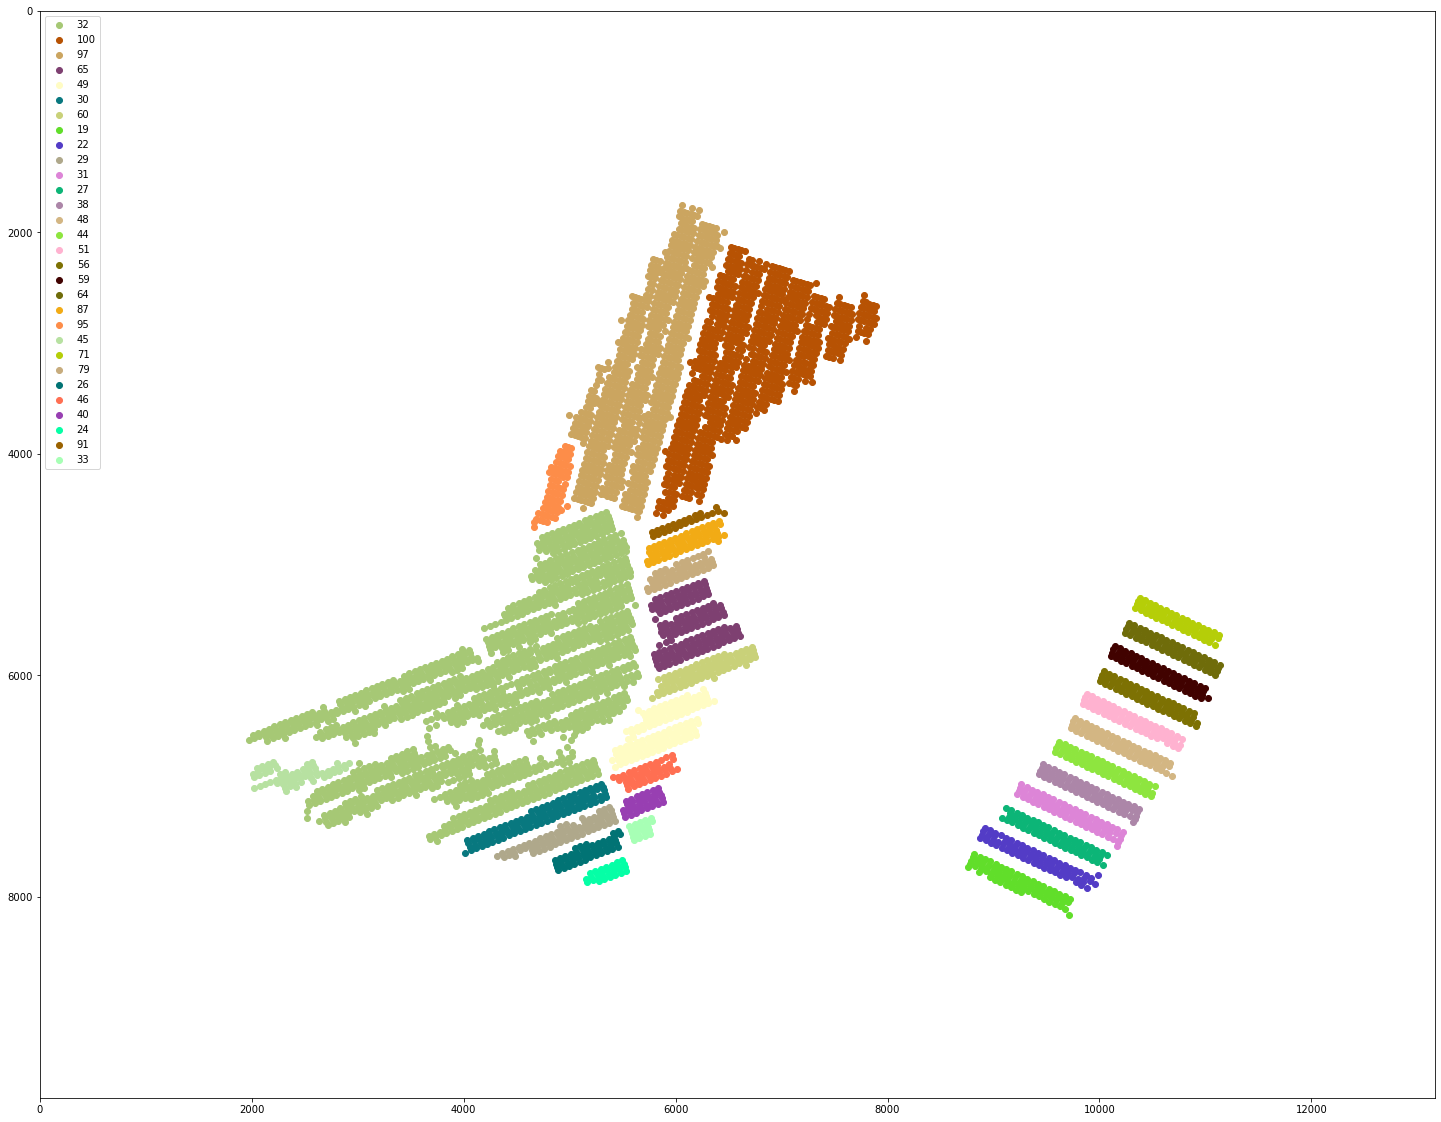

In [17]:
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
for i in array_labels:
        data = module_centers[module_labels == i]
        plt.scatter(data[:, 0], data[:, 1], color=colors[i][1], label=str(i))
ax.legend(loc='upper left')
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])
plt.show() 

真のモジュール情報のみを残す

In [18]:
true_module_contours = np.array(candidate_module_contours)[module_flags]
modules = Modules(true_module_contours) # 真のモジュール情報に更新
true_module_labels = modules.get_dbscan_labels(true_module_contours)

/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


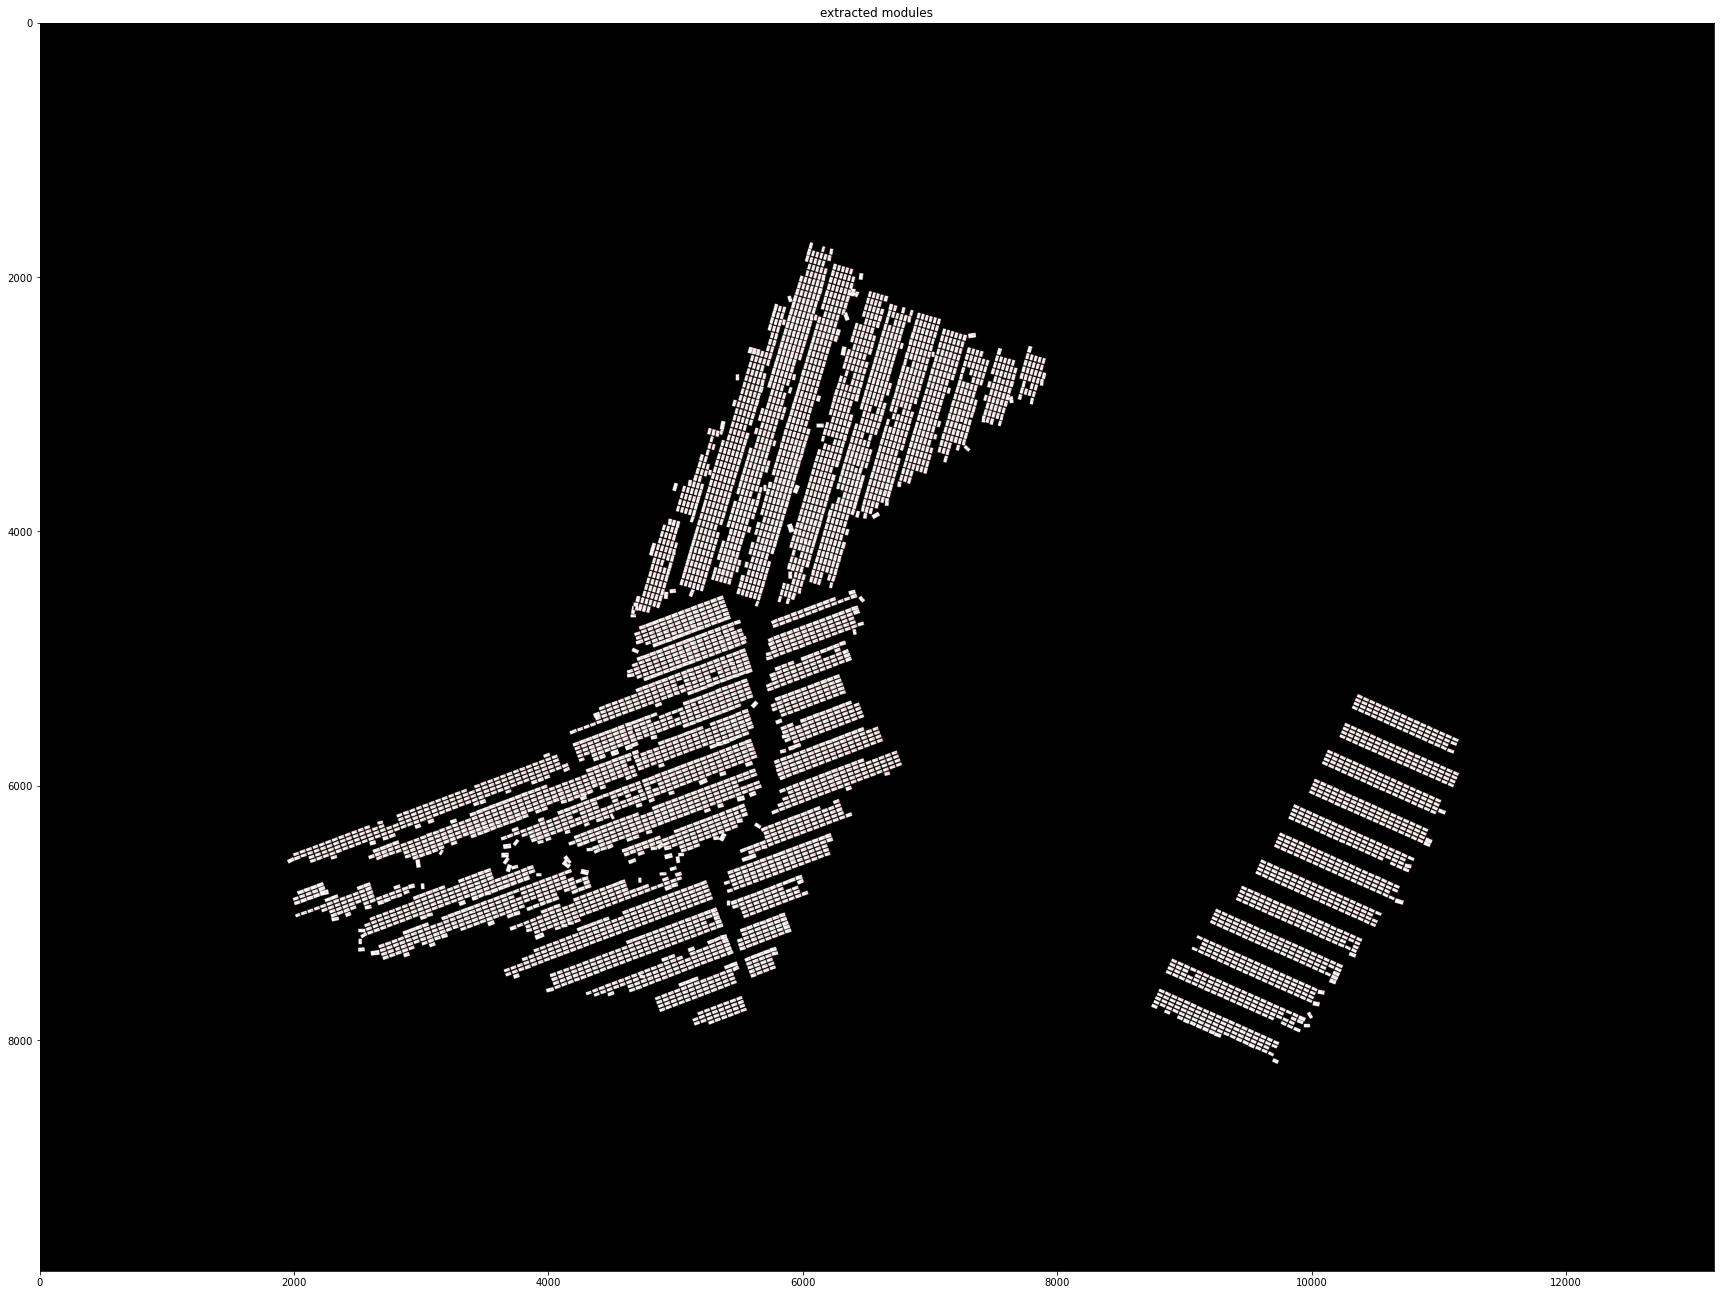

In [19]:
img_con_index = modules.get_img_contours(img_org, index=True)
module_extraction.show_img({"extracted modules":img_con_index},cmap="gray",figsize=(30,30))

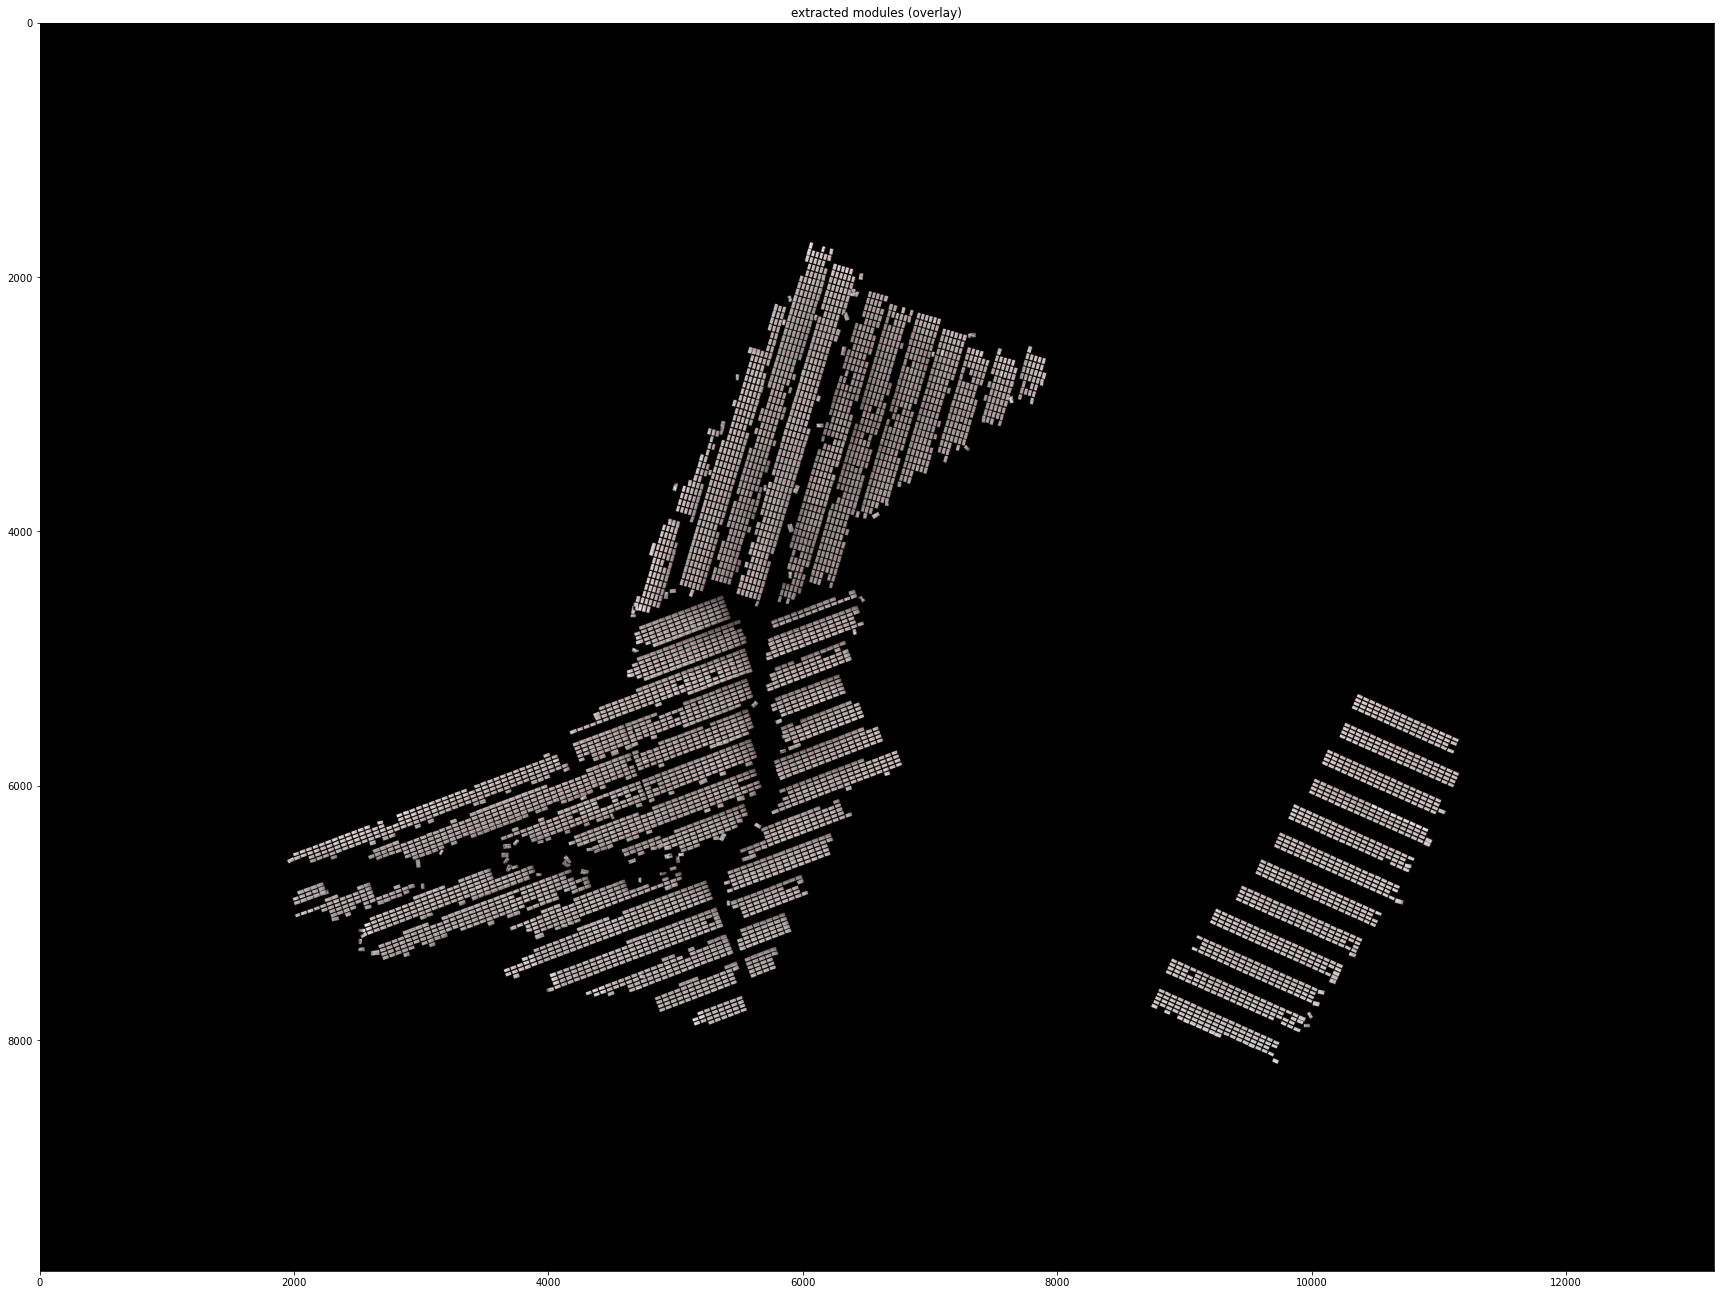

In [20]:
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
module_extraction.show_img({"extracted modules (overlay)":img_mask_index},cmap="gray",figsize=(30,30))

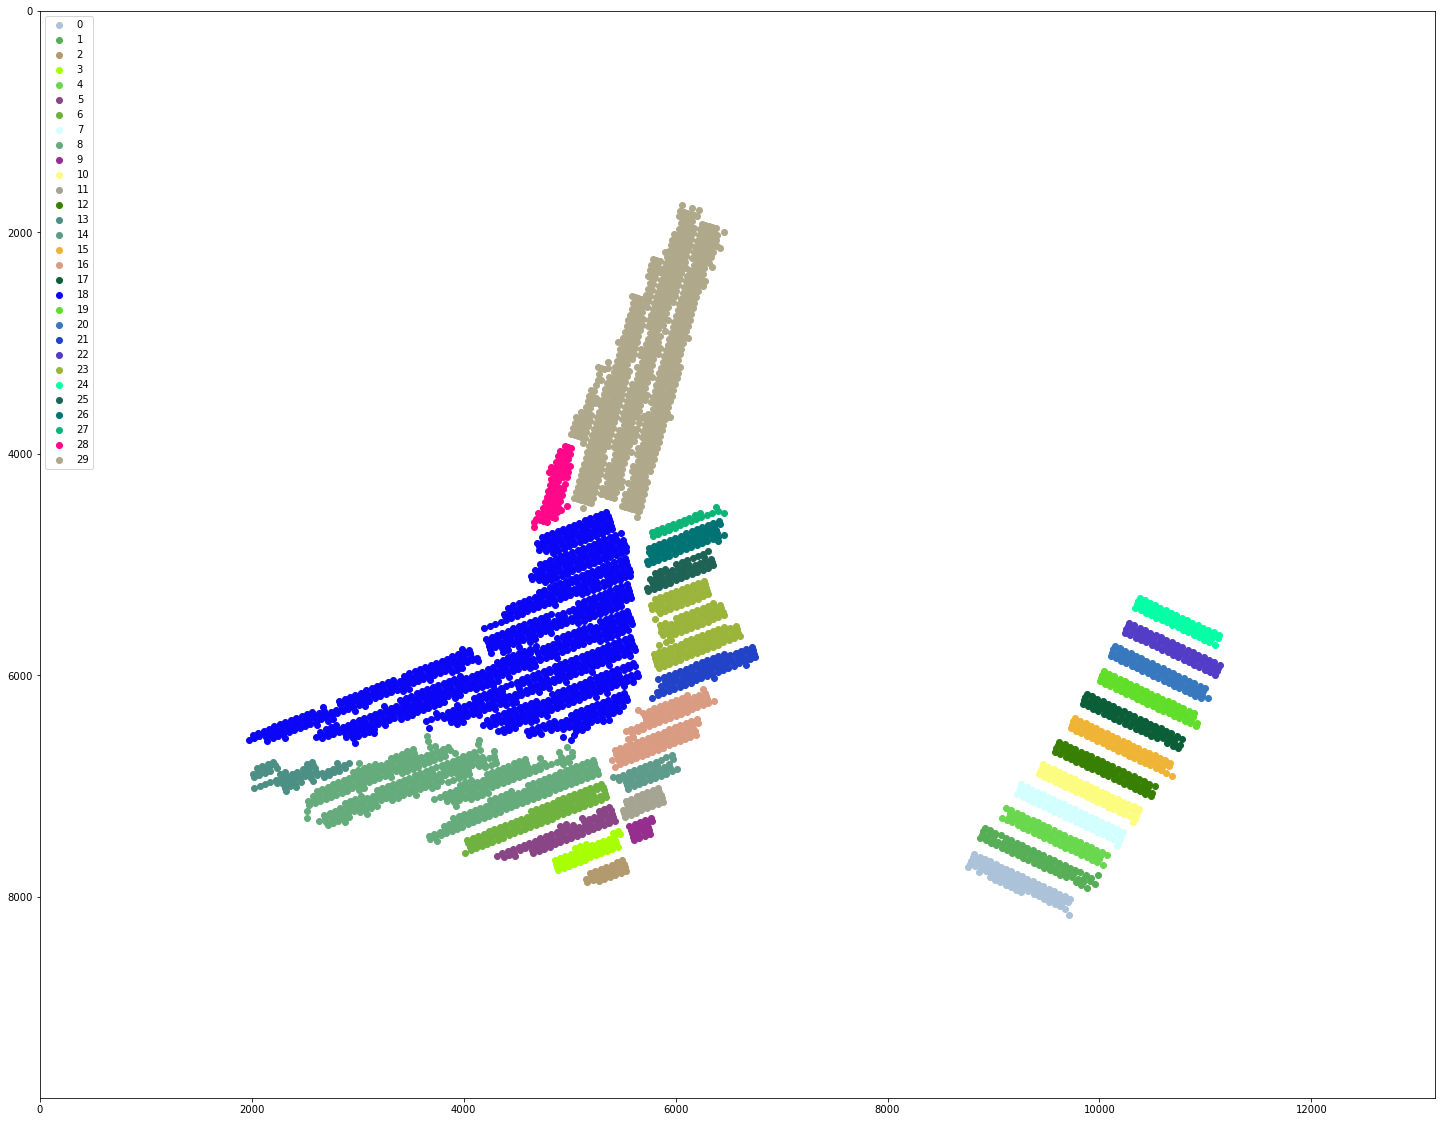

In [21]:
module_centers = np.array( [c.mean(axis=0) for c in true_module_contours] )
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
for i in range(max(true_module_labels)):
    data = module_centers[true_module_labels == i]
    plt.scatter(data[:, 0], data[:, 1], color=colors[i][1], label=str(i))
ax.legend(loc='upper left')
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])
plt.show() 

In [22]:
img_write = cv2.cvtColor(img_mask_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index.png',img_write)

False

モジュールデータの抽出

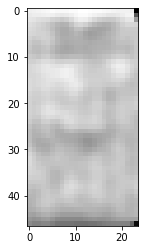

In [23]:
modules.extract_modules(img_org, output_dir_path)

In [24]:
import pickle
with open(output_dir_path+'/module_contours.pkl', 'wb') as pkl:
    pickle.dump(true_module_contours, pkl)
with open(output_dir_path+'/module_labels.pkl', 'wb') as pkl:
    pickle.dump(true_module_labels , pkl)    

ハイライトモジュールの表示（old）

In [25]:
#anomaly_contours = modules.get_anomaly_contours()
#string_anomaly_labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

In [26]:
#color_list = {
#    "Single-Hotspot": (0,255,255), # aqua
#    "Multi-Hotspots": (0,255,0), # green
#    "Cluster-Anomaly": (255,255,0), # yellow
#    "Module-Anomaly": (255,165,0), # orange
#}
#img_target_index = modules.get_img_contours(img_org, index=False)
#for k, v in anomaly_contours.items():
#    if k == "Normal":
#        continue
#    else:
#        img_target_index = modules.get_img_target_contours(
#           img_target_index, v, index=True, color=color_list[k])
#module_extraction.show_img(
#    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
#)

In [27]:
#string_anomaly_labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

In [28]:
#img_string_index = modules.get_img_target_contours(
#    modules.get_img_contours(img_org, index=False),
#    anomaly_contours["Module-Anomaly"][string_anomaly_labels>=0], 
#    index=True, color=(238,130,238)) # violet

In [29]:
# クラスタリング可視化

In [30]:
#import matplotlib.pyplot as plt

In [31]:
#centers = np.array( [c.mean(axis=0) for c in anomaly_contours["Module-Anomaly"]] )
#l = [ max(cv2.minAreaRect(c)[1]) for c in anomaly_contours["Module-Anomaly"]]
#labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

In [32]:
#fig, ax = plt.subplots(facecolor="w")
#plt.scatter(centers[:, 0], centers[:, 1])
#ax.set_xlim([0, img_con.shape[1]])
#ax.set_ylim([img_con.shape[0], 0])

In [33]:
#scaled_centers = centers / np.mean(l)

In [34]:
#fig, ax = plt.subplots(facecolor="w")
#cmap = plt.get_cmap("tab10")
#plt.scatter(scaled_centers[:, 0], scaled_centers[:, 1], color=cmap(labels+1))
#ax.set_xlim([0, int(img_con.shape[1] / np.mean(l))])
#ax.set_ylim([int(img_con.shape[0] / np.mean(l)), 0])